# Tsallisエントロピーを用いた価値反復法

---

今回はこの[論文](https://arxiv.org/pdf/1902.00137.pdf)についてコードも踏まえて解説していきたいと思います。

Tsallisエントロピー(TE)はシャノンエントロピーなどを一般化したようなものです。

次のq-logarithmを定義します。

$$
\ln _q(x) \triangleq \begin{cases}\log (x), & \text { if } q=1 \text { and } x>0 \\ \frac{x^q-1}{q-1}, & \text { if } q \neq 1 \text { and } x>0,\end{cases}
$$

この$ln_q(x)$はxに関して単調増加です。

そしてその勾配は正です。

次にTEの定義を示します。

$$
S_q(P) \triangleq \underset{X \sim P}{\mathbb{E}}\left[-\ln _q(P(X))\right]
$$

上のTEは$q>0$のときはconcave関数になり$q\leq0$のときはconvex関数になります。


---

TEを使った価値反復法は次のような作用素を適用します。

$$
\begin{gathered}
{\left[\mathcal{T}_q F\right](s, a) \triangleq \underset{s^{\prime} \sim P}{\mathbb{E}}\left[\mathbf{r}\left(s, a, s^{\prime}\right)+\gamma V_F(s) \mid s, a\right]} \\
V_F(s) \triangleq \underset{a^{\prime}}{q-\max }\left(F\left(s, a^{\prime}\right)\right) .
\end{gathered}
$$

$F$は任意の関数として考えているので、一般的な強化学習の場合の行動価値観数としてみなして大丈夫です。

ここで、q-maxは次のような定義からなります。

$$
q-\max _x(f(x)) \triangleq \max _{P \in \Delta}\left[\underset{X \sim P}{\mathbb{E}}[f(X)]+S_q(P)\right],
$$

ちなみにq-maxは$max_aQ(s,a)$を取るよりも値が大きくなることが証明されています。

---

TEは累積報酬和の他にエントロピーも考慮した最大化を目指していいるので、TEで得られて最適方策は基のMDPでの最適方策とは違います。

$\pi^*$を基のMDPでの最適方策、$\pi_q^*$をTEを考えたときの最適方策とすると、累積報酬和は次のような関係を持ちます。



$$
J\left(\pi^{\star}\right)+(1-\gamma)^{-1} \ln _q(1 /|\mathcal{A}|) \leq J\left(\pi_q^{\star}\right) \leq J\left(\pi^{\star}\right)
$$

---

コードに入っていきましょう。

qの値の違いでどれだけ価値観数が異なるのか確認していきます。


In [11]:
import numpy as np
from typing import NamedTuple
from functools import partial

S = 5 # number of states
A = 3 # number of actions
S_array = np.arange(S)
A_array = np.arange(A)

gamma = 0.9

rew = np.random.rand(S, A) # reward function
P = np.random.rand(S*A, S) # transition function
P = P / P.sum(axis=-1, keepdims=True) # normalize
P = P.reshape(S,A,S)

#MDPの定義

class MDP(NamedTuple):
    S_array : np.ndarray
    A_array : np.ndarray
    gamma : float
    rew : np.ndarray
    P : np.ndarray

    @property
    def S(self):
        return len(self.S_array)
    
    @property
    def A(self):
        return len(self.A_array)
    
mdp = MDP(S_array, A_array, gamma, rew, P)



In [63]:
# q-logarithmの定義
def q_logarithm(x,q):
    if q == 1.0:
        # print('適用')
        return np.log(x)
    else:
        return (x**(q-1)-1)/(q-1)
    
#Tsallis entropyの定義
def Tsallis_entropy(x,q):
    ent = -x * q_logarithm(x,q)
    return ent


In [72]:
import jax
import jax.numpy as jnp

@jax.jit
def value_iteration(mdp:MDP, v:jnp.ndarray):
    S,A = mdp.S,mdp.A
    v = v.max(axis = -1)
    v_dash = mdp.rew + mdp.gamma * mdp.P @ v

    max_action = jnp.zeros((S,A))
    max_action = max_action.at[np.arange(S),v_dash.argmax(axis=1)].set(1)
    return max_action * v_dash



@partial(jax.jit, static_argnames=('q'))
def Tsallis_value_iteration(mdp:MDP, v:jnp.ndarray,q:float):
    S,A = mdp.S,mdp.A
    v = v.max(axis = -1)
    v_dash = mdp.rew + mdp.gamma * mdp.P @ (v + Tsallis_entropy(1/A,q))
    max_action = jnp.zeros((S,A))
    max_action = max_action.at[np.arange(S),v_dash.argmax(axis=1)].set(1)
    return max_action * v_dash



In [73]:
from tqdm import tqdm 

key = jax.random.PRNGKey(0)
S,A = mdp.S,mdp.A
iteration = 10000
epsilon = 0.05
v_before = jax.random.uniform(key,shape=(S,A))
Q_Ent_list = []

q_list = [0.1,0.5,1.0,2.0,3.0,10.0]

for q in q_list:
    v = v_before
    for i in tqdm(range(iteration)):
        v_after = Tsallis_value_iteration(mdp,v,q)
        if jnp.abs(v_after - v).max() < epsilon:
            break
        v = v_after
    Q_Ent_list.append(v_after)




  0%|          | 26/10000 [00:00<00:28, 354.95it/s]


In [74]:
import matplotlib.pyplot as plt
from tqdm import tqdm

key = jax.random.PRNGKey(0)
S,A = mdp.S , mdp.A
iteration = 10000
errors = []
epsilon = 0.05 #閾値
v_before = jax.random.uniform(key,shape=[S,A])

for i in tqdm(range(iteration)):
    v_after = value_iteration(mdp,v_before)
    error = np.abs(v_after-v_before).max()
    #終了条件
    if error < epsilon:
        break
    errors.append(error)
    v_before = v_after

  0%|          | 26/10000 [00:00<00:35, 279.46it/s]


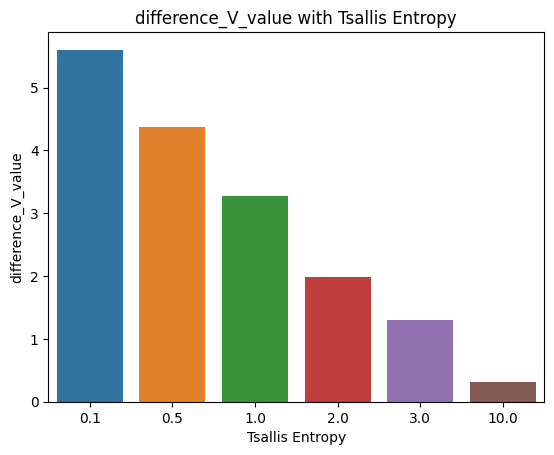

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
y_data = [(Q_Ent_list[i]-v_after).max() for i in range(len(Q_Ent_list))]
y_values = [y.item() for y in y_data]
sns.barplot(x=q_list,y=y_values)
plt.xlabel("Tsallis Entropy")
plt.ylabel("difference_V_value")
plt.title("difference_V_value with Tsallis Entropy")
plt.show()